In [1]:
import os
import sys
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset
from torchvision.transforms import functional as TF
from dataclasses import dataclass
from __future__ import annotations
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
@dataclass
class ImageDatasetConfig:
    foreground_dir: str = "shoe_dataset/"
    background_dir: str = "shoe_dataset/bg/"
    mode: str = "train"
    image_size: int = 256
    augment: bool = False
    augment_prob: float = 0.5

img_ds_config = ImageDatasetConfig()

In [3]:
# class ImageDataset(Dataset):
#     def __init__(self, image_ds_config) -> None:
#         super().__init__()

#         self.foreground_directory = image_ds_config.foreground_dir
#         self.background_directory = image_ds_config.background_dir
#         self.mode = image_ds_config.mode
#         self.image_size = image_ds_config.image_size
#         self.augment = image_ds_config.augment
#         self.augment_prob = image_ds_config.augment_prob
#         self.rotation_degree = [0, 90, 180, 270]

#         self.train_images = list(map(lambda x: f"{self.foreground_directory}train/{x}", os.listdir(f"{self.foreground_directory}/train")))
#         self.val_images = list(map(lambda x: f"{self.foreground_directory}val/{x}", os.listdir(f"{self.foreground_directory}/val")))
#         self.test_images = list(map(lambda x: f"{self.foreground_directory}test/{x}", os.listdir(f"{self.foreground_directory}/test")))
#         self.train_background_images = list(map(lambda x: f"{self.background_directory}train/{x}", os.listdir(f"{self.background_directory}/train")))
#         self.val_background_images = list(map(lambda x: f"{self.background_directory}val/{x}", os.listdir(f"{self.background_directory}/val")))

#     def __getitem__(self, index):
#         if self.mode == "train":
#             img_path = self.train_images[index]
#         elif self.mode == "val":
#             img_path = self.val_images[index]
#         else:
#             img_path = self.test_images[index]

#         return self.transform_image(img_path, self.augment)
    
#     def __len__(self):
#         if self.mode == "train":
#             return len(self.train_images)
#         elif self.mode == "val":
#             return len(self.val_images)
#         else:
#             return len(self.test_images)
    
#     def transform_image(self, img_path: str, augment: bool):
#         try:
#             image_alpha = Image.open(img_path)
#             assert str(image_alpha.mode) == 'RGBA'
#             x, y = image_alpha.size
#             aspect_ratio = y / x
#             ch_r, ch_g, ch_b, ch_a = image_alpha.split()
#             img = Image.merge('RGB', (ch_r, ch_g, ch_b))
#             mask = ch_a
            
#             if self.mode == "train":
#                 bg = Image.open(self.train_background_images[random.randint(0, len(self.train_background_images)-1)])
#                 bg = bg.resize(img.size)
#                 bg.paste(img, mask=mask)
#             else:
#                 bg = Image.open(self.val_background_images[random.randint(0, len(self.val_background_images)-1)])
#                 bg = bg.resize(img.size)
#                 bg.paste(img, mask=mask)

#             transform = list()
#             transform.append(T.Resize((self.image_size, self.image_size)))
#             transform.append(T.ToTensor())
#             transform = T.Compose(transform)

#             transformed_img = transform(bg)
#             mask = transform(mask)

#             plt.imshow(mask.permute(1, 2, 0).numpy())
#             return transformed_img, mask
#         except Exception as e:
#             print(e)
#             print(img_path)
#             transformed_img = torch.zeros(3, self.image_size, self.image_size)
#             mask = torch.zeros(1, self.image_size, self.image_size)
#             return transformed_img, mask

        

In [4]:
class ImageDataset(Dataset):
    def __init__(self, image_ds_config) -> None:
        super().__init__()

        self.foreground_directory = image_ds_config.foreground_dir
        self.background_directory = image_ds_config.background_dir
        self.mode = image_ds_config.mode
        self.image_size = image_ds_config.image_size
        self.augment = image_ds_config.augment
        self.augment_prob = image_ds_config.augment_prob
        self.rotation_degree = [0, 90, 180, 270]

        self.train_images = list(map(lambda x: f"{self.foreground_directory}train/{x}", os.listdir(f"{self.foreground_directory}/train")))
        self.val_images = list(map(lambda x: f"{self.foreground_directory}val/{x}", os.listdir(f"{self.foreground_directory}/val")))
        self.test_images = list(map(lambda x: f"{self.foreground_directory}test/{x}", os.listdir(f"{self.foreground_directory}/test")))
        self.train_background_images = list(map(lambda x: f"{self.background_directory}train/{x}", os.listdir(f"{self.background_directory}/train")))
        self.val_background_images = list(map(lambda x: f"{self.background_directory}val/{x}", os.listdir(f"{self.background_directory}/val")))

    def __getitem__(self, index):
        if self.mode == "train":
            img_path = self.train_images[index]
        elif self.mode == "val":
            img_path = self.val_images[index]
        else:
            img_path = self.test_images[index]

        return self.transform_image(img_path, self.augment)
    
    def __len__(self):
        if self.mode == "train":
            return len(self.train_images)
        elif self.mode == "val":
            return len(self.val_images)
        else:
            return len(self.test_images)
    
    def transform_image(self, img_path: str, augment: bool):
        image_alpha = Image.open(img_path)
        assert str(image_alpha.mode) == 'RGBA'
        x, y = image_alpha.size
        aspect_ratio = y / x
        ch_r, ch_g, ch_b, ch_a = image_alpha.split()
        img = Image.merge('RGB', (ch_r, ch_g, ch_b))
        mask = ch_a
        
        if self.mode == "train":
            bg = Image.open(self.train_background_images[random.randint(0, len(self.train_background_images)-1)])
            bg = bg.resize(img.size)
            bg.paste(img, mask=mask)
        else:
            bg = Image.open(self.val_background_images[random.randint(0, len(self.val_background_images)-1)])
            bg = bg.resize(img.size)
            bg.paste(img, mask=mask)

        img = bg
            
        if augment and random.random() < self.augment_prob:
            transform = list()
            resize_range = random.randint(300, 320)
            transform.append(T.Resize((int(resize_range * aspect_ratio), resize_range)))
            rot_deg = self.rotation_degree[random.randint(0, 3)]
            if rot_deg == 90 or rot_deg == 270:
                aspect_ratio = 1 / aspect_ratio
            transform.append(T.RandomRotation((rot_deg, rot_deg)))
            rot_range = random.randint(-10, 10)
            transform.append(T.RandomRotation((rot_range, rot_range)))
            crop_range = random.randint(270, 300)
            transform.append(T.CenterCrop((int(crop_range * aspect_ratio), crop_range)))
            transform = T.Compose(transform)

            img = transform(img)
            mask = transform(mask)

            transform = T.ColorJitter(brightness=0.2, contrast=0.2, hue=0.2)

            img = transform(img)

            if random.random() < 0.5:
                img = TF.hflip(img)
                mask = TF.hflip(mask)
            
            if random.random() < 0.5:
                img = TF.vflip(img)
                mask = TF.vflip(mask)
            
        transform = list()
        transform.append(T.Resize((self.image_size, self.image_size)))
        transform.append(T.ToTensor())
        transform = T.Compose(transform)

        img = transform(img)
        mask = transform(mask)

        return img, mask

In [11]:
random.choice([0, 1, 2, 3])

2

In [37]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.transforms.functional as TF

torch.manual_seed(42)

class ImageDataset(Dataset):
    def __init__(self, image_ds_config) -> None:
        super().__init__()

        self.foreground_directory = image_ds_config.foreground_dir
        self.background_directory = image_ds_config.background_dir
        self.mode = image_ds_config.mode
        self.image_size = image_ds_config.image_size
        self.augment = image_ds_config.augment
        self.augment_prob = image_ds_config.augment_prob
        self.rotation_degree = [0, 90, 180, 270]

        # Load file paths lazily when needed
        self.image_paths = self._load_image_paths()

        # Pre-load background images to avoid repeated I/O operations
        self.background_images = self._load_background_images()

        # Prepare common transforms
        self.base_transform = T.Compose([
            T.Resize((self.image_size, self.image_size)),
            T.ToTensor(),
        ])


    def __len__(self):
        return len(self.image_paths)
        

    def _load_image_paths(self):
        if self.mode == "train":
            return [os.path.join(self.foreground_directory, "train", x) for x in os.listdir(os.path.join(self.foreground_directory, "train"))]
        elif self.mode == "val":
            return [os.path.join(self.foreground_directory, "val", x) for x in os.listdir(os.path.join(self.foreground_directory, "val"))]
        else:
            return [os.path.join(self.foreground_directory, "test", x) for x in os.listdir(os.path.join(self.foreground_directory, "test"))]


    def _load_background_images(self):
        bg_dir = os.path.join(self.background_directory, self.mode)
        return [os.path.join(bg_dir, x) for x in os.listdir(bg_dir)]


    def __getitem__(self, index):
        img_path = self.image_paths[index]

        # Load and transform image and mask
        img, mask = self._load_and_process_image(img_path)

        # Apply augmentations if enabled
        if self.mode == "train" and self.augment and random.random() < self.augment_prob:
            img, mask = self._apply_augmentation(img, mask)

        # Apply final resizing and convert to tensor
        img = self.base_transform(img)
        mask = self.base_transform(mask)

        return img, mask

    def __len__(self):
        return len(self.image_paths)

    def _load_and_process_image(self, img_path: str):
        # Load the foreground image with alpha channel
        image_alpha = Image.open(img_path)
        assert image_alpha.mode == 'RGBA', "Image should be RGBA"

        img = Image.merge('RGB', image_alpha.split()[:3])
        mask = image_alpha.split()[-1]  # Alpha channel as mask

        # Select and resize a random background image
        bg_img = Image.open(random.choice(self.background_images)).resize(img.size)

        # Composite the foreground over the background using the mask
        bg_img.paste(img, mask=mask)

        return bg_img, mask

    def _apply_augmentation(self, img, mask):
        """Apply the same augmentations to both the image and the mask."""
        
        # Random Rotation
        angle = random.uniform(-10, 10)
        img = TF.rotate(img, angle)
        mask = TF.rotate(mask, angle)

        # Random Resized Crop
        i, j, h, w = T.RandomResizedCrop.get_params(img, scale=(0.8, 1.0))
        img = TF.resized_crop(img, i, j, h, w, (self.image_size, self.image_size))
        mask = TF.resized_crop(mask, i, j, h, w, (self.image_size, self.image_size))

        # Random Color Jitter (only applied to img, not mask, since mask is not RGB)
        color_jitter = T.ColorJitter(brightness=0.2, contrast=0.2, hue=0.2)
        img = color_jitter(img)

        # Random Horizontal Flip
        if random.random() > 0.5:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        # Random Vertical Flip
        if random.random() > 0.5:
            img = TF.vflip(img)
            mask = TF.vflip(mask)

        return img, mask

In [38]:
img_ds_config.augment = True

In [39]:
train_dataset = ImageDataset(img_ds_config)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

AttributeError: 'ImageDataset' object has no attribute '_get_augment_transform'

In [34]:
a, b = next(iter(train_dataloader))
print(a.shape, b.shape)

torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])


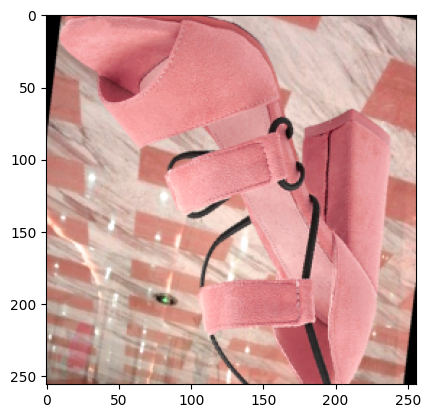

In [35]:
plt.imshow(a.squeeze(0).permute(1, 2, 0).numpy())

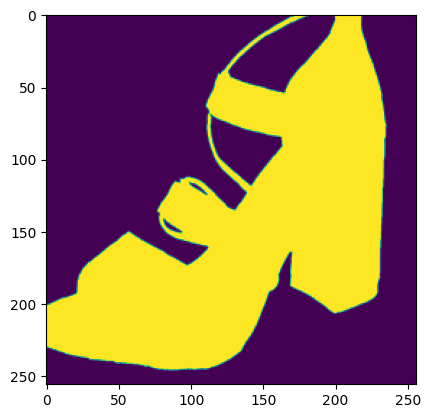

In [36]:
plt.imshow(b.squeeze(0).permute(1, 2, 0).numpy())